# Supply Network Design 2

## Objective and Prerequisites

Take your supply chain network design skills to the next level in this example. We’ll show you how – given a set of factories, depots, and customers – you can use mathematical optimization to determine which depots to open or close in order to minimize overall costs.

This model is example 20 from the fifth edition of Model Building in Mathematical Programming, by H. Paul Williams on pages 275-276 and 332-333.

This example is of beginning difficulty; we assume that you know Python and have some knowledge of the Gurobi Python API and building mathematical optimization models.

**Download the Repository** <br />
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 

---
## Problem Description

In this problem, we have six end customers, each with a known demand for a product.  Customer demand can be satisfied from a set of six depots, or directly from a set of two factories.  Each depot can support a maximum volume of product moving through it, and each factory can produce a maximum amount of product.  There are known costs associated with transporting the product, from a factory to a depot, from a depot to a customer, or from a factory directly to a customer. This extension provides the opportunity to choose which four of the six possible depots to open.  It also provides an option of expanding capacity at one specific depot.

Our supply network has two factories, in Liverpool and Brighton, that produce a product.  Each has a maximum production capacity:

| Factory | Supply (tons) |
| --- | --- |
| Liverpool | 150,000 |
| Brighton |  200,000 |

The product can be shipped from a factory to a set of six depots.  Each depot has a maximum throughput.  Depots don't produce or consume the product; they simply pass the product through to customers.

| Depot | Throughput (tons) |
| --- | --- |
| Newcastle | 70,000 |
| Birmingham | 50,000 |
| London | 100,000 |
| Exeter | 40,000 |
| Bristol | 30,000 |
| Northampton | 25,000 |

We can actually only choose four of the six depots to open.  Opening a depot has a cost:

| Depot | Cost to open |
| --- | --- |
| Newcastle | 10,000 |
| Exeter | 5,000 |
| Bristol | 12,000 |
| Northampton | 4,000 |

(Note that the description in the book talks about the cost of opening Bristol or Northampton, and the savings from closing Newcastle or Exeter, but these are simply different ways of phrasing the same choice).

We also have the option of expanding the capacity at Birmingham by 20,000 tons, for a cost of \$3000.

Our network has six customers, each with a given demand.

| Customer | Demand (tons) |
| --- | --- |
| C1 | 50,000 |
| C2 | 10,000 |
| C3 | 40,000 |
| C4 | 35,000 |
| C5 | 60,000 |
| C6 | 20,000 |

Shipping costs are given in the following table (in dollars per ton).  Columns are source cities and rows are destination cities.  Thus, for example, it costs $1 per ton to ship the product from Liverpool to London.  A '-' in the table indicates that that combination is not possible, so for example it is not possible to ship from the factory in Brighton to the depot in Newcastle.

| To | Liverpool | Brighton | Newcastle | Birmingham | London | Exeter | Briston | Northhampton
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Depots |
| Newcastle   | 0.5 |   - |
| Birmingham  | 0.5 | 0.3 |
| London      | 1.0 | 0.5 |
| Exeter      | 0.2 | 0.2 |
| Bristol     | 0.6 | 0.4 |
| Northampton | 0.4 | 0.3 |
| Customers |
| C1 | 1.0 | 2.0 |   - | 1.0 |   - |   - | 1.2 |   - |
| C2 |   - |   - | 1.5 | 0.5 | 1.5 |   - | 0.6 | 0.4 |
| C3 | 1.5 |   - | 0.5 | 0.5 | 2.0 | 0.2 | 0.5 |   - |
| C4 | 2.0 |   - | 1.5 | 1.0 |   - | 1.5 |   - | 0.5 |
| C5 |   - |   - |   - | 0.5 | 0.5 | 0.5 | 0.3 | 0.6 |
| C6 | 1.0 |   - | 1.0 |   - | 1.5 | 1.5 | 0.8 | 0.9 |

The questions to be answered: (i) Which four depots should be opened? (ii) Should Birmingham be expanded? (iii) Which depots should be used to satisfy customer demand?

---
## Model Formulation

### Sets and Indices

$f \in \text{Factories}=\{\text{Liverpool}, \text{Brighton}\}$

$d \in \text{Depots}=\{\text{Newcastle}, \text{Birmingham}, \text{London}, \text{Exeter}, \text{Bristol}, \text{Northampton}\}$

$c \in \text{Customers}=\{\text{C1}, \text{C2}, \text{C3}, \text{C4}, \text{C5}, \text{C6}\}$

$\text{Cities} = \text{Factories} \cup \text{Depots} \cup \text{Customers}$

### Parameters

$\text{cost}_{s,t} \in \mathbb{R}^+$: Cost of shipping one ton from source $s$ to destination $t$.

$\text{supply}_f \in \mathbb{R}^+$: Maximum possible supply from factory $f$ (in tons).

$\text{through}_d \in \mathbb{R}^+$: Maximum possible flow through depot $d$ (in tons).

$\text{demand}_c \in \mathbb{R}^+$: Demand for goods at customer $c$ (in tons).

$\text{opencost}_d \in \mathbb{R}^+$: Cost of opening depot $d$ (in dollars).

### Decision Variables

$\text{flow}_{s,t} \in \mathbb{N}^+$: Quantity of goods (in tons) that is shipped from source $s$ to destionation $t$.

$\text{open}_{d} \in [0,1]$: Is depot $d$ open?

$\text{expand} \in [0,1]$: Should Birmingham be expanded?


### Objective Function

- **Cost**: Minimize total shipping costs plus costs of opening depots.

\begin{equation}
\text{Minimize} \quad Z = \sum_{(s,t) \in \text{Cities} \times \text{Cities}}{\text{cost}_{s,t}*\text{flow}_{s,t}} +
                          \sum_{{d} \in \text{Depots}}{\text{opencost}_d*\text{open}_d} +
                          3000 * \text{expand}
\end{equation}

### Constraints

- **Factory output**: Flow of goods from a factory must respect maximum capacity.

\begin{equation}
\sum_{t \in \text{Cities}}{\text{flow}_{f,t}} \leq \text{supply}_{f} \quad \forall f \in \text{Factories}
\end{equation}

- **Customer demand**: Flow of goods must meet customer demand.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,c}} = \text{demand}_{c} \quad \forall c \in \text{Customers}
\end{equation}

- **Depot flow**: Flow into a depot equals flow out of the depot.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,d}} = 
\sum_{t \in \text{Cities}}{\text{flow}_{d,t}}
\quad \forall d \in \text{Depots}
\end{equation}

- **Depot capacity (all but Birmingham)**: Flow into a depot must respect depot capacity, and is only allowed if the depot is open.

\begin{equation}
\sum_{s \in \text{Cities}}{\text{flow}_{s,d}} \leq \text{through}_{d} * \text{open}_{d}
\quad \forall d \in \text{Depots} - \text{Birmingham}
\end{equation}

- **Depot capacity (Birmingham)**: Flow into Birmingham must respect depot capacity, which may have been expanded.

\begin{equation}
\sum_{s \in \text{Cities}} \text{flow}_{s,\text{Birmingham}} \leq \text{through}_{\text{Birmingham}} + 20000 * \text{expand}
\end{equation}

- **Open depots**: At most 4 open depots (no choice for Birmingham or London).

\begin{equation}
\sum_{d \in \text{Depots}}{\text{open}_{d}} \leq 4
\end{equation}

\begin{equation}
\text{open}_{\text{Birmingham}} = \text{open}_{\text{London}} = 1
\end{equation}

---
## Python Implementation

We import the Gurobi Python Module and other Python libraries.

In [ ]:
#%pip install gurobipy

In [44]:
import pandas as pd

import gurobipy as gp
from gurobipy import GRB

# tested with Python 3.12 & Gurobi 12.0

## Input Data
We define all the input data for the model.

In [47]:
# Create dictionaries to capture factory supply limits, depot throughput limits, cost of opening depots, and customer demand.

supply = dict({'Liverpool': 150000,
               'Brighton': 200000})

through = dict({'Newcastle': 70000,
                'Birmingham': 50000,
                'London': 100000,
                'Exeter': 40000,
                'Bristol': 30000,
                'Northampton': 25000})

opencost = dict({'Newcastle': 10000,
                 'Birmingham': 0,
                 'London': 0,
                 'Exeter': 5000,
                 'Bristol': 12000,
                 'Northampton': 4000})

demand = dict({'C1': 50000,
               'C2': 10000,
               'C3': 40000,
               'C4': 35000,
               'C5': 60000,
               'C6': 20000})

# Create a dictionary to capture shipping costs.

arcs, cost = gp.multidict({
    ('Liverpool', 'Newcastle'): 0.5,
    ('Liverpool', 'Birmingham'): 0.5,
    ('Liverpool', 'London'): 1.0,
    ('Liverpool', 'Exeter'): 0.2,
    ('Liverpool', 'Bristol'): 0.6,
    ('Liverpool', 'Northampton'): 0.4,
    ('Liverpool', 'C1'): 1.0,
    ('Liverpool', 'C3'): 1.5,
    ('Liverpool', 'C4'): 2.0,
    ('Liverpool', 'C6'): 1.0,
    ('Brighton', 'Birmingham'): 0.3,
    ('Brighton', 'London'): 0.5,
    ('Brighton', 'Exeter'): 0.2,
    ('Brighton', 'Bristol'): 0.4,
    ('Brighton', 'Northampton'): 0.3,
    ('Brighton', 'C1'): 2.0,
    ('Newcastle', 'C2'): 1.5,
    ('Newcastle', 'C3'): 0.5,
    ('Newcastle', 'C5'): 1.5,
    ('Newcastle', 'C6'): 1.0,
    ('Birmingham', 'C1'): 1.0,
    ('Birmingham', 'C2'): 0.5,
    ('Birmingham', 'C3'): 0.5,
    ('Birmingham', 'C4'): 1.0,
    ('Birmingham', 'C5'): 0.5,
    ('London', 'C2'): 1.5,
    ('London', 'C3'): 2.0,
    ('London', 'C5'): 0.5,
    ('London', 'C6'): 1.5,
    ('Exeter', 'C3'): 0.2,
    ('Exeter', 'C4'): 1.5,
    ('Exeter', 'C5'): 0.5,
    ('Exeter', 'C6'): 1.5,
    ('Bristol', 'C1'): 1.2,
    ('Bristol', 'C2'): 0.6,
    ('Bristol', 'C3'): 0.5,
    ('Bristol', 'C5'): 0.3,
    ('Bristol', 'C6'): 0.8,
    ('Northampton', 'C2'): 0.4,
    ('Northampton', 'C4'): 0.5,
    ('Northampton', 'C5'): 0.6,
    ('Northampton', 'C6'): 0.9
})

## Model Deployment

We create a model and the variables. The 'flow' variables simply capture the amount of product that flows along each allowed path between a source and destination.  The 'open' variable capture decisions about which depots to open.  The 'expand' variable captures the choice of whether to expand Birmingham.  Objective coefficients are provided here, so we don't need to provide an optimization objective later.

In [50]:
model = gp.Model('SupplyNetworkDesign2')

depots = through.keys()
flow = model.addVars(arcs, obj=cost, name="flow")
open = model.addVars(depots, obj=opencost, vtype=GRB.BINARY, name="open")
expand = model.addVar(obj=3000, vtype=GRB.BINARY, name="expand")

open['Birmingham'].lb = 1
open['London'].lb = 1
model.objcon = -(opencost['Newcastle'] + opencost['Exeter']) # Phrased as 'savings from closing'

Our first constraints require the total flow along arcs leaving a factory to be at most as large as the supply capacity of that factory.

In [53]:
# Production capacity limits

factories = supply.keys()
factory_flow = model.addConstrs((gp.quicksum(flow.select(factory, '*')) <= supply[factory]
                                 for factory in factories), name="factory")

Our next constraints require the total flow along arcs entering a customer to be equal to the demand from that customer.

In [56]:
# Customer demand

customers = demand.keys()
customer_flow = model.addConstrs((gp.quicksum(flow.select('*', customer)) == demand[customer]
                                  for customer in customers), name="customer")

Our final constraints relate to depots.  The first constraints require that the total amount of product entering the depot must equal the total amount leaving.

In [59]:
# Depot flow conservation

depot_flow = model.addConstrs((gp.quicksum(flow.select(depot, '*')) == gp.quicksum(flow.select('*', depot))
                               for depot in depots), name="depot")

The second set limits the product passing through the depot to be at most equal the throughput of that deport, or 0 if the depot isn't open.

In [65]:
# Depot throughput

all_but_birmingham = list(set(depots) - set(['Birmingham']))

depot_capacity = model.addConstrs((gp.quicksum(flow.select(depot, '*')) <= through[depot]*open[depot]
                                   for depot in all_but_birmingham), name="depot_capacity")

The capacity constraint for Birmingham is different.  The depot is always open, but we have the option of expanding its capacity.

In [67]:
birmingham_capacity = model.addConstr(gp.quicksum(flow.select('*', 'Birmingham')) <= through['Birmingham'] +
                                      20000*expand, name="birmingham_capacity")

Finally, there's a limit of at most 4 open depots

In [69]:
# Depot count

depot_count = model.addConstr(open.sum() <= 4)

## Visualizing the problem
We draw the directed graph with **graphviz** package.

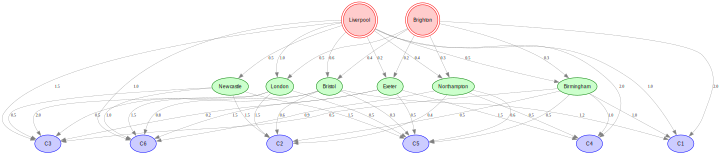

In [86]:
from graphviz import Digraph

# Define colours and styles
factory_style = {'shape': 'doublecircle', 'color': 'red', 'style': 'filled', 'fillcolor': '#FFCCCC'}
depot_style = {'color': 'green', 'style': 'filled', 'fillcolor': '#CCFFCC'}
customer_style = {'color': 'blue', 'style': 'filled', 'fillcolor': '#CCCCFF'}
edge_style = {'color': 'gray', 'penwidth': '0.5'}

# Create the graph with some layout settings
dot = Digraph(graph_attr={'rankdir': 'TB',     # TOP-to_Bottom
                          'size': '10,10',     # Larger image
                          'nodesep': '0.5',    # Distance between nodes
                          'ranksep': '1.0'     # Distance between levels
                         },
              node_attr={'fontsize': '10',
                         'fontname': 'Arial'
                        },
              edge_attr=edge_style
             )

# Add nodes with styles
for factory in factories:
    dot.node(factory,  **factory_style)
for depot in depots:
    dot.node(depot, **depot_style)
for customer in customers:
    dot.node(customer, **customer_style)

# Add edges with costs as labels    
for arc in arcs:
    dot.edge(arc[0], arc[1],
             label=f"{cost[arc[0],arc[1]]}", 
             fontsize='8', 
             fontcolor='black')
        
dot

We now optimize the model

In [71]:
model.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 49 columns and 119 nonzeros
Model fingerprint: 0x0e70b441
Variable types: 42 continuous, 7 integer (7 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [2e-01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 2e+05]
Presolve removed 1 rows and 2 columns
Presolve time: 0.01s
Presolved: 20 rows, 47 columns, 113 nonzeros
Variable types: 42 continuous, 5 integer (5 binary)
Found heuristic solution: objective 174000.00000

Root relaxation: cutoff, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff 

---
## Analysis

The product demand from all of our customers can be satisfied for a total cost of $\$174,000$ by opening a depot in Northampton, closing the depot in Newcastle, and expanding the depot in Birmingham:

In [77]:
print('List of open depots:', [d for d in depots if open[d].x > 0.5])
if expand.x > 0.5:
    print('Expand Birmingham')

List of open depots: ['Birmingham', 'London', 'Exeter', 'Northampton']
Expand Birmingham


In [83]:
product_flow = pd.DataFrame(
    [{"From":arc[0], "To": arc[1], "Flow": flow[arc].X} for arc in arcs if flow[arc].x > 1e-6]
)
product_flow.index=[''] * len(product_flow)
product_flow

,From,To,Flow
,Liverpool,C1,50000.0
,Liverpool,C6,20000.0
,Brighton,Birmingham,70000.0
,Brighton,London,10000.0
,Brighton,Exeter,40000.0
,Brighton,Northampton,25000.0
,Birmingham,C2,10000.0
,Birmingham,C4,10000.0
,Birmingham,C5,50000.0
,London,C5,10000.0


## Visualize flows

In [89]:
def draw_solution(model, flow):
    
    # Define colours and styles
    factory_style = {'shape': 'doublecircle', 'color': 'red', 'style': 'filled', 'fillcolor': '#FFCCCC'}
    depot_style = {'color': 'green', 'style': 'filled', 'fillcolor': '#CCFFCC'}
    customer_style = {'color': 'blue', 'style': 'filled', 'fillcolor': '#CCCCFF'}
    edge_style = {'color': 'gray', 'penwidth': '0.5'}

    # Create the graph with some layout settings
    dot = Digraph(graph_attr = {'rankdir': 'TB',
                              'size': '10,10',
                              'nodesep': '0.5',
                              'ranksep': '1.0'
                               },
                 node_attr = {'fontsize': '10',
                            'fontname': 'Arial'
                             },
                 edge_attr = edge_style
                 )
    # Add factory-nodes with styles
    for factory in factories:
        dot.node(factory,  **factory_style)
    #Add depot-nodes with styles
    for depot in depots:
        dot.node(depot, **depot_style)
    # Add customer-nodes with styles
    for customer in customers:
        dot.node(customer, **customer_style)

    # Add edges with costs as labels 
    for arc in arcs:
        if flow[arc].X > 0:
            dot.edge(arc[0], arc[1],
                     label=f"{cost[arc[0], arc[1]]}  @ {flow[arc[0],arc[1]].X}",
                     color='red',
                     fontsize='10'
                    )
        else:
            dot.edge(arc[0], arc[1],
                     fontsize='8', 
                     fontcolor='black'
                    )

    return dot

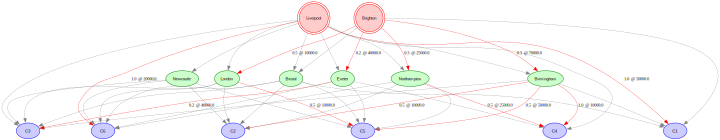

In [91]:
draw_solution(model, flow)

---
## References

H. Paul Williams, Model Building in Mathematical Programming, fifth edition.

Copyright © 2020 Gurobi Optimization, LLC